# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

`customerID`  - это primary key для всех таблиц.

Информация о договорах актуальна на 1 февраля 2020.


- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип договора: ежемесячный, годовой и т.д,
- PaperlessBilling – факт выставления счёта на электронную почту,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги,
- Dependents – наличие иждивенцев,
- Senior Citizen – наличие пенсионного статуса по возрасту,
- Partner – наличие супруга(и),
- MultipleLines – наличие возможности ведения параллельных линий во время звонка.

**Цель**:
построить модель бинарной классификации пользователей оператора связи на пользователей, которые с высокой вероятностью могут отказаться от услуг оператора, и лояльных. Заказчик сможет предпринять меры, способствующие удержанию нелояльных пользователей.

**План решения задачи:**
1. Постановка цели
2. Знакомство с данными.
3. Предобработка данных
4. Обзор отдельных датасетов. Анализ.
5. Объединение датасетов. Feature engineering: выделение таргета, phik для категориальных данных, correlation matrix для численных по отношению к таргету.
6. Подготовка признаков: кодируем категориальные признаки. Подготовим pipeline
7. Определяем 2-3 модели для проверки на валидационной выборке. Параметры подбираем через GridSearchCV для проверки на cv. В качестве метрики выбираем ROC-AUC.
8. Финальный тест на тестовой выборке, измерение accuracy
9. Выводы

## Обзор данных

### Импорт библиотек

In [2]:
pip install phik

     |████████████████████████████████| 679 kB 2.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade scikit-learn

     |████████████████████████████████| 9.6 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 33.1 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import re
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from patsy import dmatrices

from sklearn.utils import shuffle
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant  
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, FunctionTransformer, OneHotEncoder
from phik import report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, \
                                PrecisionRecallDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import SGDClassifier
from catboost import Pool, CatBoostClassifier, cv
from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import StackingClassifier

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [5]:
random_state = 300123

## Загрузка, обзор подготовка датасетов

In [6]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

### Датасет данных по договорам `df_contract`

In [7]:
df_contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

In [8]:
df_contract.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 3.2 MB


In [9]:
for i in df_contract:
    print(i)
    try:
        print(df_contract[i].unique().sorted())
    except:
        print(df_contract[i].unique())
    print()

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

BeginDate
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11

Столбец 'TotalCharges' содержит значения, равные ' '. Это не позволяет преобразовать тип данных столбца. Это пользователи, которые зарегистрировались у провайдера в месяце выгрузки данных, и еще не успели заплатить ни одного платежа. Исключим эти значения( 11 шт.) из БД и преобразуем тип данных столбца

In [10]:
df_contract[df_contract['TotalCharges'] == ' '].count()

customerID          11
BeginDate           11
EndDate             11
Type                11
PaperlessBilling    11
PaymentMethod       11
MonthlyCharges      11
TotalCharges        11
dtype: int64

In [11]:
df_contract = df_contract[df_contract['TotalCharges'] != ' '] 

In [12]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float64')

In [13]:
df_contract.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 2.9 MB


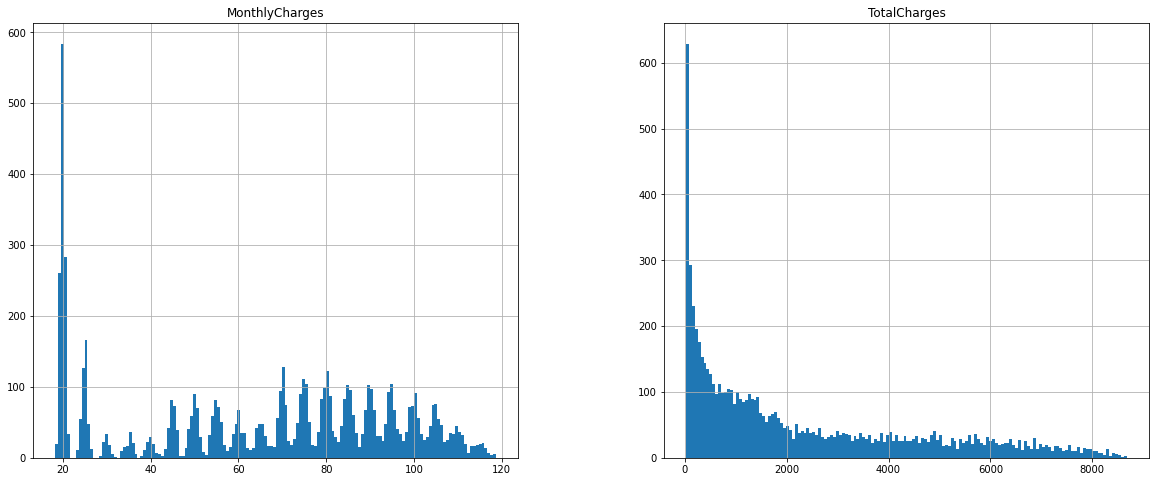

In [14]:
df_contract.hist(bins=150, figsize=(20,8));

In [15]:
df_contract.describe()

MonthlyCharges  TotalCharges
count     7032.000000   7032.000000
mean        64.798208   2283.300441
std         30.085974   2266.771362
min         18.250000     18.800000
25%         35.587500    401.450000
50%         70.350000   1397.475000
75%         89.862500   3794.737500
max        118.750000   8684.800000

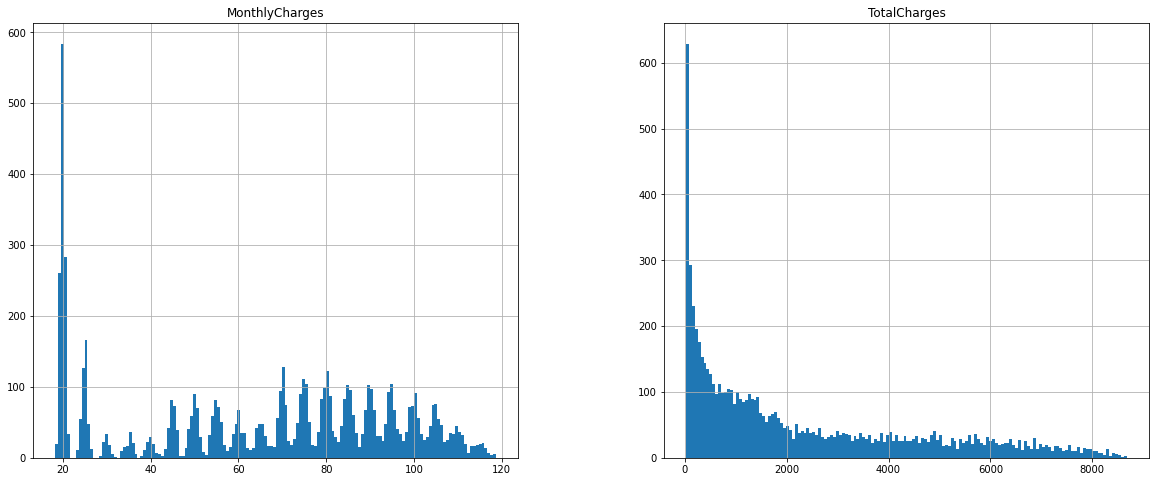

In [16]:
df_contract[df_contract['EndDate'].notna()].hist(bins=150, figsize=(20,8));

Выводы 1:
1. Пик регистраций новыъ пользоваетелей был в 2014м году. Вероятно в данный период условия были очень выгодными- для набора клиентской базы.
2. Следующий значимый рост числа новых пользователей был в 2019-м году и достиг соизмеримого с 2014-м годом значения в последние 5 месяцев.
3. Примечательно, что начало оттока пользователей (450-500 каждый месяц) совпало с ростом 2019-года. Предположительно качество сервисов ухудшилось, а тарифы теперь не такие выгодные,  какие были при запуске компании. 
4. Отток в основном идет из новых пользователей. И ежемесячные платежи этих пользователей значительно выше средних
5. Ежемесячный отток превышает приход новых пользователей 4 месяца подряд - с 10.2019 по 01.2020
6. Средний пользователь перевел на счет оператора 2283 у.е. при среднем месячном платеже 64.79. Значит пользователи в среднем пользуются услугами не менее 35 месяцев.

Выводы 2:
1. Требуется корректировка типов данных. Выполнена.
2. Требуется корректировка наименований столбцов. Выполним после объединения датасетов.

### Датасет пользователей услуги интернет `df_internet`

In [17]:
df_internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [18]:
df_internet.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 2.6 MB


In [19]:
df_internet.duplicated().sum()

0

In [20]:
for i in df_internet:
    print(i)
    try:
        print(df_internet[i].unique().sorted())
    except:
        print(df_internet[i].unique())
    print()

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

InternetService
['DSL' 'Fiber optic']

OnlineSecurity
['No' 'Yes']

OnlineBackup
['Yes' 'No']

DeviceProtection
['No' 'Yes']

TechSupport
['No' 'Yes']

StreamingTV
['No' 'Yes']

StreamingMovies
['No' 'Yes']



InternetService  InternetService
DSL              DSL                2421
Fiber optic      Fiber optic        3096
Name: InternetService, dtype: int64



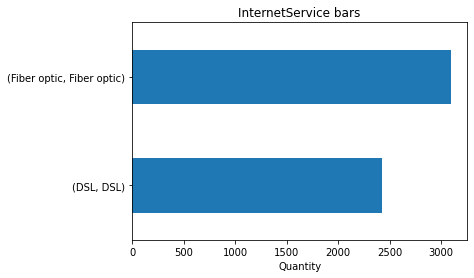

InternetService  OnlineSecurity
DSL              No                1241
                 Yes               1180
Fiber optic      No                2257
                 Yes                839
Name: OnlineSecurity, dtype: int64



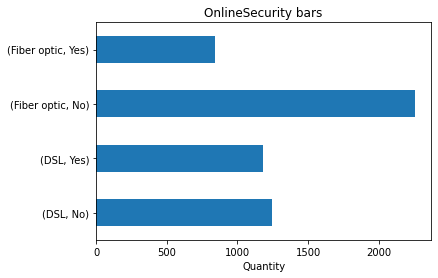

InternetService  OnlineBackup
DSL              No              1335
                 Yes             1086
Fiber optic      No              1753
                 Yes             1343
Name: OnlineBackup, dtype: int64



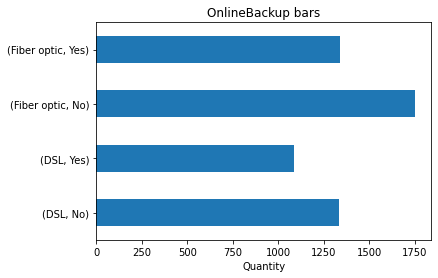

InternetService  DeviceProtection
DSL              No                  1356
                 Yes                 1065
Fiber optic      No                  1739
                 Yes                 1357
Name: DeviceProtection, dtype: int64



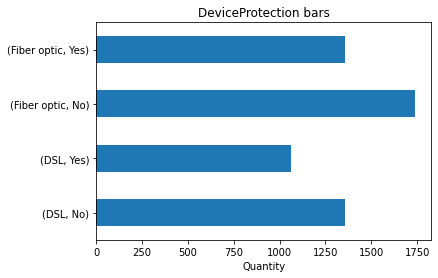

InternetService  TechSupport
DSL              No             1243
                 Yes            1178
Fiber optic      No             2230
                 Yes             866
Name: TechSupport, dtype: int64



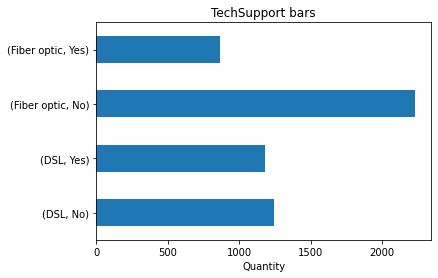

InternetService  StreamingTV
DSL              No             1464
                 Yes             957
Fiber optic      Yes            1750
                 No             1346
Name: StreamingTV, dtype: int64



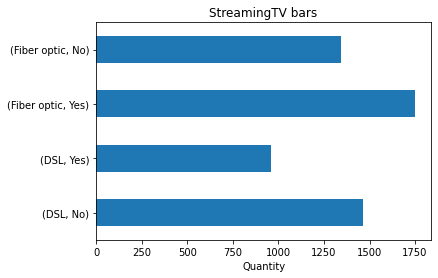

InternetService  StreamingMovies
DSL              No                 1440
                 Yes                 981
Fiber optic      Yes                1751
                 No                 1345
Name: StreamingMovies, dtype: int64



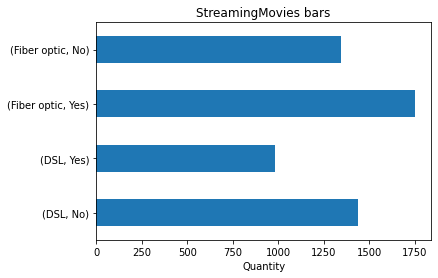

In [21]:
for i in df_internet.columns[1:]:
    try:
        a = df_internet.groupby('InternetService')[i].value_counts()
        print(a)
        a.plot(kind='barh');
        print()
        plt.title(i + ' bars')
        plt.xlabel('Quantity')
        plt.ylabel('')
        plt.show();
    except:
        continue

Выводы:
1. Большая часть пользователей перешла на оптоволокно
2. Доп.сервисами пользуются, но закономерностей здесь невидно

### Датасет данных пользователей `df_personal`

In [22]:
df_personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [23]:
df_personal.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 1.7 MB


In [24]:
df_personal.duplicated().sum()

0

In [25]:
for i in df_personal:
    print(i)
    try:
        print(df_personal[i].unique().sorted())
    except:
        print(df_personal[i].unique())
    print()

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

gender
['Female' 'Male']

SeniorCitizen
[0 1]

Partner
['Yes' 'No']

Dependents
['No' 'Yes']



In [26]:
df_personal.describe()

SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

gender  gender
Female  Female    1.0
Male    Male      1.0
Name: gender, dtype: float64



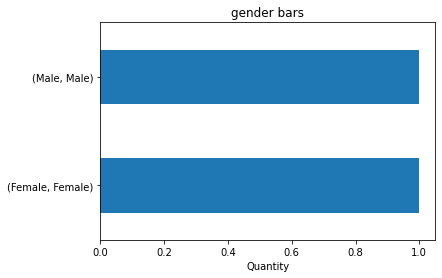

gender  SeniorCitizen
Female  0                0.837156
        1                0.162844
Male    0                0.838537
        1                0.161463
Name: SeniorCitizen, dtype: float64



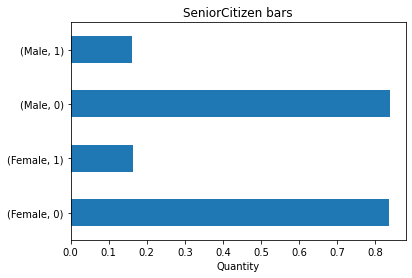

gender  Partner
Female  No         0.516055
        Yes        0.483945
Male    No         0.517862
        Yes        0.482138
Name: Partner, dtype: float64



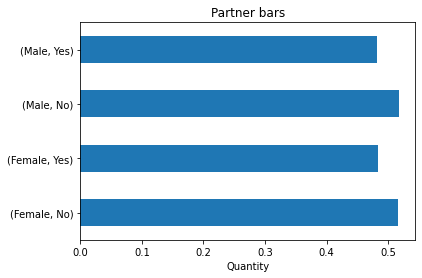

gender  Dependents
Female  No            0.705275
        Yes           0.294725
Male    No            0.695640
        Yes           0.304360
Name: Dependents, dtype: float64



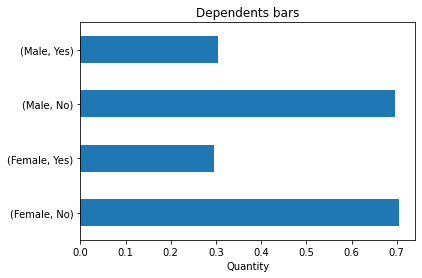

In [27]:
for i in df_personal.columns[1:]:
    try:
        a = df_personal.groupby('gender')[i].value_counts(normalize=True)
        print(a);
        a.plot(kind='barh');
        plt.title(i + ' bars')
        plt.xlabel('Quantity')
        plt.ylabel('')
        print()
        plt.show();
    except:
        print('a')

Выводы:
1. Соотношение мужчин и женщин среди пользователей одинаковое.
2. Доля пенсионеров среди обоих полов одинаковая и составляет 16%
3. Доля женатых пользователей составляет 30 % (суммарно и отдельно по полам)
4. Доля пользователей, имеющих на иждивении несовершеннолетних, - 30%

### Датасет данных пользователей телефонии `df_phone`

In [28]:
df_phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [29]:
df_phone.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 785.7 KB


In [30]:
len(df_phone)/len(df_contract) * 100

90.45790671217291

In [31]:
df_phone.duplicated().sum()

0

df_phone.replace({'Yes': True, 'No': False}, inplace=True)

MultipleLines
No     3390
Yes    2971
Name: customerID, dtype: int64


Text(0, 0.5, '')

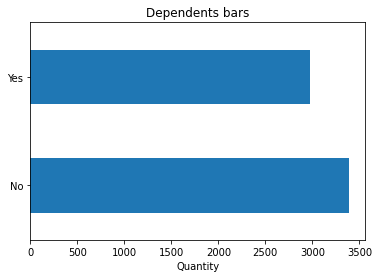

In [32]:
a = df_phone.groupby('MultipleLines')['customerID'].count()
print(a);
a.plot(kind='barh');
plt.title(i + ' bars')
plt.xlabel('Quantity')
plt.ylabel('')

Вывод:
1. Большая часть пользователей оператора пользуется телефонией - 90.45%. 
2. Среди пользователей телефонии больше пользователей (3390 против 2971) не пользуются услугой параллельных линий звонков.

## Подготовка итогового датасета

### Объединение датсетов и подготовка признаков:

Объединим датасеты и откорректируем наименования признаков:

In [33]:
df_full = df_contract.merge(df_personal, how='inner', on='customerID')
df_full = df_full.merge(df_internet, how='left', on='customerID')
df_full = df_full.merge(df_phone, how='left', on='customerID')

df_full.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', x).lower() for x in df_full.columns]

Целевой признак - `end_date`. Если пользователь расторг договор - "1", остался - "0":

In [34]:
df_full.loc[df_full['end_date'] == 'No', 'end_date'] = 0
df_full.loc[df_full['end_date'] != 0, 'end_date'] = 1

Проверим пропуски после объединения датасетов:

In [35]:
df_full.isna().sum()

customer_i_d            0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_t_v        1520
streaming_movies     1520
multiple_lines        680
dtype: int64

После объединения появились пропуски в услугах у тех абонентов, которые пользовались только одной услугой - телефонией либо интернетом. Для таких пропусков вводим отдельную категоию "no"

In [36]:
df_full.fillna('no internet', inplace=True)

Посчитаем длительность действия договора в месяцах на момент выгрузки данных для каждого пользователя. После этого столбец можно отбросить, также как и `customer_i_d` за остутствием пользы:

In [37]:
df_full['begin_date'] = pd.to_datetime(df_full['begin_date'])

In [38]:
df_full['month'] = pd.Timestamp("2020-02-01")
df_full['month'] = round((df_full['month'] - df_full['begin_date']) / np.timedelta64(1, 'M'))
df_full.drop('customer_i_d', axis=1, inplace=True)
df_full.drop('begin_date', axis=1, inplace=True)

Заменим значения для дальнейшей возможности перевода в тип данных `bool`:

### Feature Engineering:

Проверим численные признаки на наличие линейной корреляции по Пирсону:

<AxesSubplot:>

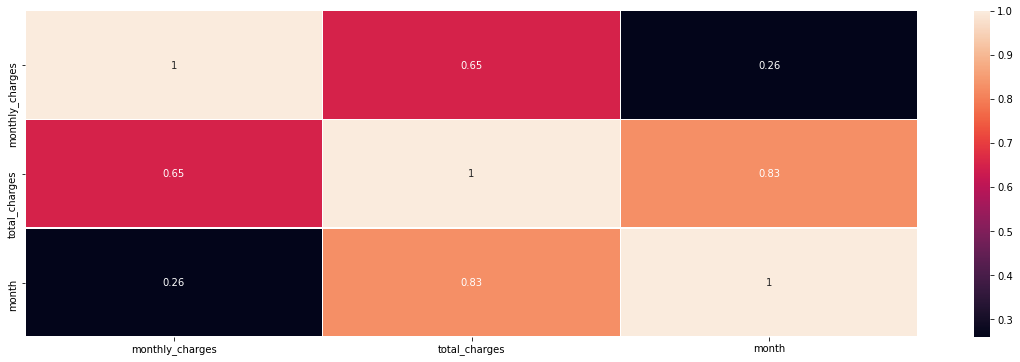

In [39]:
plt.subplots(figsize=(20, 6))
sns.heatmap(df_full.select_dtypes(include=['float64', 'int8']).corr(), annot=True, linewidth=.5)

`total_charges` имеет очень высокую корелляцию с `month` и высокую с `month_charges` и фактически дублирует его ифнформацию. необходимо отбросить данный признак.

Проверим категориальные признаки на предмет мультиколлинейрности по phi k:

In [40]:
phik_overview = df_full.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['end_date', 'monthly_charges', 'total_charges', 'senior_citizen', 'month']


end_date  type  paperless_billing  payment_method  \
end_date               1.00  0.25               0.30            0.45   
type                   0.25  1.00               0.11            0.28   
paperless_billing      0.30  0.11               1.00            0.37   
payment_method         0.45  0.28               0.37            1.00   
monthly_charges        0.36  0.39               0.47            0.40   
total_charges          0.28  0.51               0.21            0.35   
gender                 0.00  0.00               0.00            0.00   
senior_citizen         0.23  0.09               0.24            0.29   
partner                0.23  0.18               0.01            0.24   
dependents             0.25  0.15               0.17            0.22   
internet_service       0.20  0.50               0.23            0.32   
online_security        0.21  0.64               0.21            0.31   
online_backup          0.18  0.58               0.20            0.29   
device_protection      0.17  0.63               0.20            0.30   
tech_support           0.21  0.67               0.20            0.32   
streaming_t_v          0.14  0.55               0.20            0.28   
streaming_movies       0.14  0.55               0.20            0.28   
multiple_lines         0.02  0.24               0.10            0.17   
month                  0.42  0.67               0.03            0.37   

                   monthly_charges  total_charges  gender  senior_citizen  \
end_date                      0.36           0.28    0.00            0.23   
type                          0.39           0.51    0.00            0.09   
paperless_billing             0.47           0.21    0.00            0.24   
payment_method                0.40           0.35    0.00            0.29   
monthly_charges               1.00           0.76    0.01            0.30   
total_charges                 0.76           1.00    0.00            0.15   
gender                        0.01           0.00    1.00            0.00   
senior_citizen                0.30           0.15    0.00            1.00   
partner                       0.20           0.42    0.00            0.02   
dependents                    0.18           0.12    0.00            0.32   
internet_service              0.92           0.51    0.00            0.16   
online_security               0.81           0.53    0.00            0.13   
online_backup                 0.82           0.57    0.00            0.11   
device_protection             0.83           0.57    0.00            0.11   
tech_support                  0.82           0.54    0.00            0.14   
streaming_t_v                 0.86           0.57    0.00            0.11   
streaming_movies              0.86           0.57    0.00            0.11   
multiple_lines                0.71           0.49    0.00            0.09   
month                         0.43           0.85    0.00            0.01   

                   partner  dependents  internet_service  online_security  \
end_date              0.23        0.25              0.20             0.21   
type                  0.18        0.15              0.50             0.64   
paperless_billing     0.01        0.17              0.23             0.21   
payment_method        0.24        0.22              0.32             0.31   
monthly_charges       0.20        0.18              0.92             0.81   
total_charges         0.42        0.12              0.51             0.53   
gender                0.00        0.00              0.00             0.00   
senior_citizen        0.02        0.32              0.16             0.13   
partner               1.00        0.65              0.00             0.09   
dependents            0.65        1.00              0.11             0.12   
internet_service      0.00        0.11              1.00             0.95   
online_security       0.09        0.12              0.95             1.00   
online_backup         0.09        0.

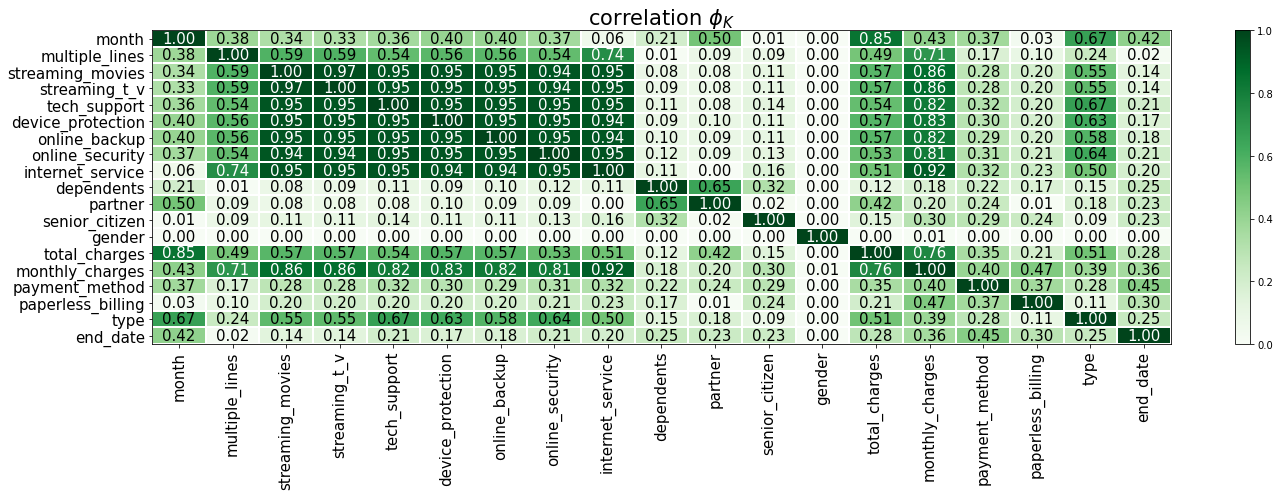

In [41]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 7));
plt.tight_layout()

Мультиколлинеарность между доп.услугами продукта "интернет". Данные признаки необходимо отбросить.

Проверим мультиколлинеарность числовых признаков с таргетом `end_date` через коэффициент инфляции дисперсии VIF

In [42]:
y, X = dmatrices('end_date ~ type+paperless_billing+payment_method+monthly_charges+gender+senior_citizen+partner \
    +total_charges+dependents+internet_service+online_security+online_backup+device_protection+tech_support \
    +streaming_t_v+streaming_movies+multiple_lines+month', data=df_full, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [43]:
vif.sort_values(by='VIF', ascending=False)

VIF                                   variable
15          inf               online_backup[T.no internet]
11          inf            internet_service[T.no internet]
23          inf            streaming_movies[T.no internet]
21          inf               streaming_t_v[T.no internet]
19          inf                tech_support[T.no internet]
17          inf           device_protection[T.no internet]
13          inf             online_security[T.no internet]
0   1963.665178                                  Intercept
26   866.021779                            monthly_charges
10   148.502824            internet_service[T.Fiber optic]
25    34.894157              multiple_lines[T.no internet]
22    24.156224                    streaming_movies[T.Yes]
20    24.079875                       streaming_t_v[T.Yes]
28    10.535585                              total_charges
29     7.309982                                      month
24     7.291241                      multiple_lines[T.Yes]
16     6.924913                   device_protection[T.Yes]
14     6.796724                       online_backup[T.Yes]
18     6.477567                        tech_support[T.Yes]
12     6.338643                     online_security[T.Yes]
2      2.636085                           type[T.Two year]
5      1.975065         payment_method[T.Electronic check]
6      1.856790             payment_method[T.Mailed check]
1      1.617801                           type[T.One year]
4      1.561070  payment_method[T.Credit card (automatic)]
8      1.462630                             partner[T.Yes]
9      1.381669                          dependents[T.Yes]
3      1.208810                   paperless_billing[T.Yes]
27     1.153498                             senior_citizen
7      1.002103                             gender[T.Male]

In [44]:
df_full.drop(['monthly_charges'], inplace=True, axis=1)

In [45]:
y, X = dmatrices('end_date ~ type+paperless_billing+payment_method+gender+senior_citizen+partner \
    +total_charges+dependents+internet_service+online_security+online_backup+device_protection+tech_support \
    +streaming_t_v+streaming_movies+multiple_lines+month', data=df_full, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [46]:
vif.sort_values(by='VIF', ascending=False)

VIF                                   variable
11        inf            internet_service[T.no internet]
23        inf            streaming_movies[T.no internet]
21        inf               streaming_t_v[T.no internet]
19        inf                tech_support[T.no internet]
17        inf           device_protection[T.no internet]
15        inf               online_backup[T.no internet]
13        inf             online_security[T.no internet]
0   18.210124                                  Intercept
27  10.507635                              total_charges
28   7.298784                                      month
2    2.636064                           type[T.Two year]
10   2.373206            internet_service[T.Fiber optic]
5    1.975028         payment_method[T.Electronic check]
6    1.856630             payment_method[T.Mailed check]
22   1.734724                    streaming_movies[T.Yes]
20   1.719737                       streaming_t_v[T.Yes]
1    1.617786                           type[T.One year]
4    1.561069  payment_method[T.Credit card (automatic)]
16   1.546834                   device_protection[T.Yes]
18   1.542927                        tech_support[T.Yes]
12   1.481144                     online_security[T.Yes]
14   1.476129                       online_backup[T.Yes]
8    1.462169                             partner[T.Yes]
24   1.457084                      multiple_lines[T.Yes]
25   1.423435              multiple_lines[T.no internet]
9    1.381610                          dependents[T.Yes]
3    1.208720                   paperless_billing[T.Yes]
26   1.153467                             senior_citizen
7    1.001973                             gender[T.Male]

In [47]:
for i in ['paperless_billing', 'gender', 'senior_citizen','partner', 'dependents', 'online_security', 'online_backup', 
          'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies']:
    df_full[i] = df_full[i].astype('category')
    
for i in ['type', 'payment_method', 'multiple_lines', 'internet_service']:
    df_full[i] = df_full[i].astype('category')
          
for i in ['month']:
    df_full[i] = df_full[i].astype('float64')

df_full.drop(['streaming_movies', 'streaming_t_v', 
              'tech_support', 'device_protection', 'online_backup', 'online_security'], axis=1, inplace=True)

## Подготовка моделей и сравнительное тестирование:

### Выделение целевого признака и работа с дисбалансом классов:

Посчитаем соотношение классов в целевом признаке для задания весов:

In [50]:
print(df_full['end_date'].value_counts())
class_ratio = df_full['end_date'].value_counts()[0] / df_full['end_date'].value_counts()[1]
dict_classes = {0: class_ratio, 
                1: 1}

0    5163
1    1869
Name: end_date, dtype: int64


In [51]:
dict_classes

{0: 2.7624398073836276, 1: 1}

"Нулей" в 2.76 раза больше, чем "единиц" - ушедших пользователей. Разделим датасет на тренеровочную и тестовую выборки и произведем upsampling редкого признака "1"

Выделение таргета и признаков:

In [52]:
target = df_full['end_date']
original_features = df_full.drop('end_date', axis=1)

Разделение на выборки::

In [53]:
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=random_state, stratify=target)

Подготовим функцию `upsample` и масштабируем редкий признак для устранения дисбаланса классов:

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros]  + [features_ones] * 3)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * 3)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=random_state)
    
    return features_upsampled, target_upsampled

original_features, target = upsample(original_features, target, class_ratio)

dict_classes = {0: 1, 
                1: 1}

### Подготовка pipeline для нормализации и кодирования  признаков:

In [54]:
scaler = StandardScaler() 
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

numerical = list(original_features_train.select_dtypes(include='number').columns)
categorical = list(original_features_train.select_dtypes(include='category').columns)

num_pipe = Pipeline([
    ('scaler', scaler)
])
cat_pipe = Pipeline([
    ('ohe', ohe)
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numerical),
    ('cat', cat_pipe, categorical)
])

### SGDClassifier

In [54]:
regressor_SGD = SGDClassifier(early_stopping=True)
pipeline_sgd = Pipeline([("preprocessing", preprocessor), ("modelling", regressor_SGD)])

param_grid_sgd = dict(
                modelling__penalty = ['l1', 'l2'],
                modelling__loss = ['hinge', 'log', 'modified_huber', 'huber'],
                modelling__learning_rate = ['optimal', 'adaptive'],
                modelling__eta0 = [0.7, 1.0, 1.5],
                modelling__class_weight = [dict_classes],
                modelling__random_state = [random_state]
                  )

grid_SGD = GridSearchCV(pipeline_sgd, param_grid=param_grid_sgd, cv=5, n_jobs=-1, scoring= 'roc_auc', verbose=2)
grid_SGD.fit(original_features_train, target_train)

print('# Tuning hyper-parameters for ROC_AUC score')
best_score_SGD = grid_SGD.best_score_
best_params_SGD = grid_SGD.best_params_
best_model_SGD = grid_SGD.best_estimator_
mean_fittime_SGD = grid_SGD.cv_results_['mean_fit_time'].mean()
mean_predicttime_SGD = grid_SGD.cv_results_['mean_score_time'].mean()

print(f"Best score {best_score_SGD} found on development set:")
print()
print(best_params_SGD)
print()

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__eta0=0.7, modelling__learning_rate=optimal, modelling__loss=hinge, modelling__penalty=l1, modelling__random_state=300123; total time=   0.3s
[CV] END modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__eta0=0.7, modelling__learning_rate=optimal, modelling__loss=hinge, modelling__penalty=l1, modelling__random_state=300123; total time=   0.5s
[CV] END modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__eta0=0.7, modelling__learning_rate=optimal, modelling__loss=hinge, modelling__penalty=l1, modelling__random_state=300123; total time=   0.6s
[CV] END modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__eta0=0.7, modelling__learning_rate=optimal, modelling__loss=hinge, modelling__penalty=l1, modelling__random_state=300123; total time=   0.4s
[CV] END modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling_

### CatBoostClassifier

#### Через Pipeline

In [55]:
regressor_cat = CatBoostClassifier()
pipeline_cat = Pipeline([("preprocessing", preprocessor), ("modelling", regressor_cat)])

param_grid_cat = dict(
                modelling__iterations = [300, 500, 600, 700],
                modelling__learning_rate = [0.1, 0.2, 0.3],
                modelling__random_state = [random_state]
                  )

grid_cat_p = GridSearchCV(pipeline_cat, param_grid=param_grid_cat, cv=5, n_jobs=-1, scoring= 'roc_auc', verbose=2)
grid_cat_p.fit(original_features_train, target_train)

print('# Tuning hyper-parameters for ROC_AUC score')
best_score_cat_p = grid_cat_p.best_score_
best_params_cat_p = grid_cat_p.best_params_
best_model_cat_p = grid_cat_p.best_estimator_
mean_fittime_cat_p = grid_cat_p.cv_results_['mean_fit_time'].mean()
mean_predicttime_cat_p = grid_cat_p.cv_results_['mean_score_time'].mean()

print(f"Best score {best_score_cat_p} found on development set:")
print()
print(best_params_cat_p)
print()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0:	learn: 0.6348162	total: 49.3ms	remaining: 14.7s
1:	learn: 0.5880400	total: 51.5ms	remaining: 7.67s
2:	learn: 0.5477441	total: 53.8ms	remaining: 5.32s
3:	learn: 0.5166906	total: 56ms	remaining: 4.14s
4:	learn: 0.4955850	total: 58.2ms	remaining: 3.44s
5:	learn: 0.4787148	total: 60.5ms	remaining: 2.96s
6:	learn: 0.4601763	total: 62.7ms	remaining: 2.63s
7:	learn: 0.4412631	total: 64.9ms	remaining: 2.37s
8:	learn: 0.4319076	total: 67.3ms	remaining: 2.18s
9:	learn: 0.4211945	total: 69.5ms	remaining: 2.01s
10:	learn: 0.4154585	total: 71.7ms	remaining: 1.88s
11:	learn: 0.4093284	total: 74ms	remaining: 1.77s
12:	learn: 0.4016556	total: 76.2ms	remaining: 1.68s
13:	learn: 0.3928717	total: 78.3ms	remaining: 1.6s
14:	learn: 0.3888329	total: 80.6ms	remaining: 1.53s
15:	learn: 0.3839890	total: 83ms	remaining: 1.47s
16:	learn: 0.3799373	total: 85.3ms	remaining: 1.42s
17:	learn: 0.3784411	total: 87.8ms	remaining: 1.37s
18:	learn: 0.3756970

#### Без предобработки признаков:

In [56]:
cat_model = CatBoostClassifier(cat_features=categorical)

parameters = {'iterations':[200, 300, 500],
              'learning_rate':[0.1, 0.3, 0.5] }

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
grid_cat = GridSearchCV(cat_model, 
                   parameters, 
                   scoring='roc_auc',
                   verbose=2,
                   n_jobs=-1,
                   cv=5)
grid_cat.fit(original_features_train, target_train)


print('# Tuning hyper-parameters for ROC_AUC score')
best_score_cat = grid_cat.best_score_
best_params_cat = grid_cat.best_params_
best_model_cat = grid_cat.best_estimator_
mean_fittime_cat = grid_cat.cv_results_['mean_fit_time'].mean()
mean_predicttime_cat = grid_cat.cv_results_['mean_score_time'].mean()

print(f"Best score {best_score_cat} found on development set:")
print()
print(best_params_cat)
print()

# Tuning hyper-parameters for root_mean_squared_error

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0:	learn: 0.6412100	total: 17.3ms	remaining: 3.44s
1:	learn: 0.5834504	total: 30.2ms	remaining: 2.99s
2:	learn: 0.5526580	total: 40.9ms	remaining: 2.69s
3:	learn: 0.5260093	total: 50ms	remaining: 2.45s
4:	learn: 0.5003754	total: 62ms	remaining: 2.42s
5:	learn: 0.4775682	total: 73.6ms	remaining: 2.38s
6:	learn: 0.4670992	total: 77.3ms	remaining: 2.13s
7:	learn: 0.4565876	total: 85.5ms	remaining: 2.05s
8:	learn: 0.4423025	total: 97.5ms	remaining: 2.07s
9:	learn: 0.4316843	total: 109ms	remaining: 2.06s
10:	learn: 0.4262568	total: 116ms	remaining: 1.99s
11:	learn: 0.4222049	total: 126ms	remaining: 1.97s
12:	learn: 0.4170649	total: 135ms	remaining: 1.95s
13:	learn: 0.4135483	total: 145ms	remaining: 1.93s
14:	learn: 0.4068511	total: 157ms	remaining: 1.93s
15:	learn: 0.4030535	total: 167ms	remaining: 1.93s
16:	learn: 0.3991207	total: 180ms	remaining: 1.93s
17:	learn: 0.3931508	to

### LGBMClassifier

In [57]:
regressor_LGBM = LGBMClassifier()
pipeline_LGBM = Pipeline([("preprocessing", preprocessor), ("modelling", regressor_LGBM)])

param_grid_LGBM = dict(
                modelling__num_leaves = [10, 15, 31],
                modelling__learning_rate = [0.1, 0.15, 0.3],
                modelling__n_estimators = [20, 35, 50],
                modelling__class_weight = [dict_classes],
                modelling__random_state = [random_state]
                  )

grid_LGBM = GridSearchCV(pipeline_LGBM, param_grid=param_grid_LGBM, cv=5, n_jobs=1, scoring= 'roc_auc', verbose=2)
grid_LGBM.fit(original_features_train, target_train)

print('# Tuning hyper-parameters for ROC_AUC score')
best_score_LGBM = grid_LGBM.best_score_
best_params_LGBM = grid_LGBM.best_params_
best_model_LGBM = grid_LGBM.best_estimator_
mean_fittime_LGBM = grid_LGBM.cv_results_['mean_fit_time'].mean()
mean_predicttime_LGBM = grid_LGBM.cv_results_['mean_score_time'].mean()

print(f"Best score {best_score_LGBM} found on development set:")
print()
print(best_params_LGBM)
print()

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__learning_rate=0.1, modelling__n_estimators=20, modelling__num_leaves=10, modelling__random_state=300123; total time=   0.2s
[CV] END modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__learning_rate=0.1, modelling__n_estimators=20, modelling__num_leaves=10, modelling__random_state=300123; total time=   0.2s
[CV] END modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__learning_rate=0.1, modelling__n_estimators=20, modelling__num_leaves=10, modelling__random_state=300123; total time=   0.3s
[CV] END modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__learning_rate=0.1, modelling__n_estimators=20, modelling__num_leaves=10, modelling__random_state=300123; total time=   0.4s
[CV] END modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__learning_rate=0.1, modelling__n_estimators=20, modelling__num_leave

### RidgeClassifier

In [58]:
regressor_Ridge = RidgeClassifier()
pipeline_Ridge = Pipeline([("preprocessing", preprocessor), ("modelling", regressor_Ridge)])

param_grid_Ridge = dict(
                modelling__alpha = [0.1, 1, 10, 100],
                modelling__solver = ['svd', 'cholesky', 'lsqr','sparse_cg'],
                modelling__class_weight = [dict_classes],
                modelling__random_state = [random_state]
                  )

grid_Ridge = GridSearchCV(pipeline_Ridge, param_grid=param_grid_Ridge, cv=5, n_jobs=1, scoring= 'roc_auc', verbose=2)
grid_Ridge.fit(original_features_train, target_train)

print('# Tuning hyper-parameters for ROC_AUC score')
best_score_Ridge = grid_Ridge.best_score_
best_params_Ridge = grid_Ridge.best_params_
best_model_Ridge = grid_Ridge.best_estimator_
mean_fittime_Ridge = grid_Ridge.cv_results_['mean_fit_time'].mean()
mean_predicttime_Ridge = grid_Ridge.cv_results_['mean_score_time'].mean()

print(f"Best score {best_score_Ridge} found on development set:")
print()
print(best_params_Ridge)
print()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END modelling__alpha=0.1, modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__random_state=300123, modelling__solver=svd; total time=   0.2s
[CV] END modelling__alpha=0.1, modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__random_state=300123, modelling__solver=svd; total time=   0.4s
[CV] END modelling__alpha=0.1, modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__random_state=300123, modelling__solver=svd; total time=   0.4s
[CV] END modelling__alpha=0.1, modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__random_state=300123, modelling__solver=svd; total time=   0.4s
[CV] END modelling__alpha=0.1, modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__random_state=300123, modelling__solver=svd; total time=   0.4s
[CV] END modelling__alpha=0.1, modelling__class_weight={0: 2.7624398073836276, 1: 1}, modelling__random_state=300123, modelling__solver=cho

## Сравнительная таблица результатов моделей:

In [59]:
index = ['SGD',
         'CatBoost',
         'CatBoost without pipeline',
         'LGBMRegressor',
         'Ridge']

data = {'ROC-AUC score на CV, евро':[best_score_SGD,
                                     best_score_cat_p,
                                     best_score_cat,
                                     best_score_LGBM,
                                     best_score_Ridge],
        
        'ROC_AUC > 0.85':[best_score_SGD > 0.85,
                          best_score_cat_p > 0.85,
                          best_score_cat > 0.85,
                          best_score_LGBM > 0.85,
                          best_score_Ridge > 0.85],
        
        'time fitting':    [mean_fittime_SGD,
                            mean_fittime_cat_p,
                            mean_fittime_cat,
                            mean_fittime_LGBM,
                            mean_fittime_Ridge],
                            
        'time predicting':  [mean_predicttime_SGD,
                             mean_predicttime_cat_p,
                             mean_predicttime_cat,
                             mean_predicttime_LGBM,
                             mean_predicttime_Ridge]}
pivot = pd.DataFrame(data=data, index=index)
print(pivot)

In [60]:
pivot

ROC-AUC score на CV, евро  ROC_AUC > 0.85  \
SGD                                         0.837031           False   
CatBoost                                    0.916260            True   
CatBoost without pipeline                   0.916688            True   
LGBMRegressor                               0.913937            True   
Ridge                                       0.832735           False   

                           time fitting  time predicting  
SGD                            0.831864         0.135448  
CatBoost                       1.791635         0.020659  
CatBoost without pipeline      4.788221         0.006394  
LGBMRegressor                  0.351654         0.055182  
Ridge                          0.223077         0.105502

Для итогового тестирования отбираем модель CatBoost с pipe-line подготовкой признаков, т.к. у нее максимальная метрика roc_auc при втором по скорости результате обучения и втором по скорости результате предсказания. 

## Проверка лучшей модели на тестовой выборке:

Полученим вероятностей классов и предсказаний для метрик:

In [56]:
predicttions_probs = best_model_cat_p.predict_proba(original_features_test)
predictions = best_model_cat_p.predict(original_features_test)

Метрики:

In [57]:
print('Roc_auc:', roc_auc_score(target_test, predicttions_probs[:, 1]))
print('Accuracy:', accuracy_score(target_test, predictions))
print('Precision:', precision_score(target_test, predictions))
print('Recall:', recall_score(target_test, predictions))

Roc_auc: 0.9352708671630479
Accuracy: 0.888509670079636
Precision: 0.8329238329238329
Recall: 0.7259100642398287


Построим график кривой AUC_ROC:

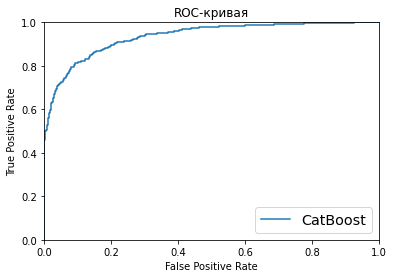

Площадь под ROC-кривой: 0.9352708671630479


In [58]:
probabilities_one_test = predicttions_probs[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.plot(fpr, tpr, label='CatBoost')


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()
print('Площадь под ROC-кривой:', roc_auc_score(target_test, probabilities_one_test))

Оценка значимости признаков для предсказаний модели:

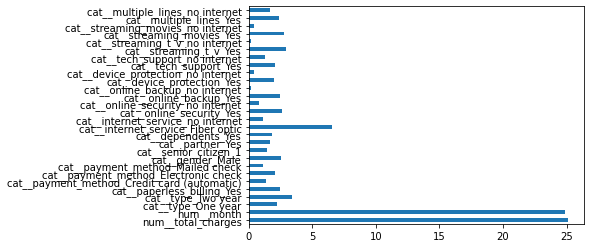

In [59]:
columns=grid_cat_p.best_estimator_[:-1].get_feature_names_out()
feat_importances = pd.Series(grid_cat_p.best_estimator_._final_estimator.feature_importances_, index=columns)
feat_importances.plot(kind='barh');

## Отчет:
1. Результатом текущей работы стала модель машинного обучения для бинарной классификации предсказания ухода пользователя провайдера интернет- и телефонных услуг. Заказчик модели сможет использовать ее для своевременной заботы о пользователях и недопущения дальнейшего оттока.
2. Согласно плана успешно выполнены шаги: постановка цели-знакомство с данными-предобработка-обзор датасетов-анализ-объединение датасетов-отбор признаков-подготовка признаков через pipeline-подбор гиперпараметров моделей с оценкой метрики AUC_ROC-финальный проверка лучшей модели на тестовой выборке.
3. Самым сложным этапом для меня был этап отбора признаков и борьбы с мультиколлинеарностью: оказалось, что мультиколлинеарность невсегда влияет на метрики качества модели, а при ошибочном отбрасвании признаков можно на длительное время столкнуться с невозможностью поднять метрику. В следующий раз я бы начал с baseline модели до feature_engineering, чтобы увидеть минимальную метрику на простейшней модели. И только после этого начал бы отбирать признаки.
4. Ключевым этапом для меня стала борьба с мультиколлинеарностью, т.к. я отбросил признаки, имеющиеся характеристику коллинеарных, до первой модели, и не мог
5. Исследовательский анализ данных показал, что массовый отток пользователей совпал с массовым приростом новых пользователей. При этом покидают оператора связи преимущественно новые пользователи - стоимость тарифов для них выше, а в поддержку чаще обращаются пользователи оптоволокна (на DSL - старые пользователи).
6. В качестве представления заказчику отобрана модель Catboost, работающая на алгоритме стохастического градиентного  спуска. Лучших результатов модель достигла при гиперпараметрах:
* 'modelling__iterations': 600
* 'modelling__learning_rate': 0.3
* 'modelling__random_state': 300123

Признаки для нее проходят подготовку через pipeline с нормализацией для числовых и порядковым кодированием(ohe) для категориальных признаков.

7. Модель Catboost показала следующие результыты:
* `AUC_ROC` = 0.935
* Точность `accuracy` показала значение 0.891
* Полнота `Recall`= 0.727 означает, что модель верно обнаруживает 72.7% действительно готовящихся к уходу пользователей
* Точность `precision` = 0.844. 84.4% положительных предсказаний действительно оказываются положительными
8. Метрики модель Catboost практически не изменилась от предобработки признаков через pipeline по сравнению с прямым указанием категориальных признаков.
9. Модель Catboost оказалась нечувствительой к наличию мультиколлинеарности между признаками. Однако мультиколлинеарность проанализирована через коэффициент корреляции Пирсона, phi k, VIF. В результате был отброшен признак `monthly_charges` - размер ежемесяыных платежей. Вместо даты заключения договора подготовлен искуственный признак `month` - он отражает длительность действующего с пользователем договора на момент выгрузки БД 01.02.2020.
10. Для работы модели оставлены оставшиеся признаки: 'type',
 'paperless_billing',
 'payment_method',
 'total_charges',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_t_v',
 'streaming_movies',
 'multiple_lines',
 'month'
11. Обзор значимости признаков на предсказания модели показал, что влияние на целевой признак оказывает срок работы с клиентом `month` и его суммарные платежи `total_charges`. Исследовательский анализ показал: чаще всего провайдера покидают новые пользователи, пользователи с высокими ежемесячными платежами. Пользователи заключившие длительные контракты (на 2 года)разрывают контракты реже.  